In [2]:
import pandas as pd
from pandas import HDFStore, DataFrame
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import re
import random
import sklearn
from sklearn.model_selection import train_test_split
import glob
import geopy.distance
from math import radians, cos, sin, asin, sqrt

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.models import load_model
import typhon
from typhon.retrieval.qrnn import QRNN
from math import radians, cos, sin, asin, sqrt

import itertools
import matplotlib.gridspec as gridspec
from matplotlib.ticker import LogFormatter
from matplotlib.colors import LogNorm

In [3]:
def closest_quantile_to_threshold(preds, threshold):
    closest_quantile = 0
    for i in range(0,len(preds)):
        tmp_pred = preds[i]
        if tmp_pred < threshold and closest_quantile < 8:
            closest_quantile = closest_quantile + 1
    return closest_quantile

def get_qrnn_PoP(qrnn_preds, threshold, quantiles):
    PoP = 100 * (1 - quantiles[closest_quantile_to_threshold(qrnn_preds, threshold)])
    return PoP

In [4]:
# Load networks
qrnn_name = "qrnn_12_128_more_data"
qrnn = QRNN.load(qrnn_name)

In [5]:
input_path   = '/home/teodor/Documents/QRNN_GPM_project/database_testing/qrnn_input'
gprof_path   = '/home/teodor/Documents/QRNN_GPM_project/database_testing/gprof_retrievals'
gt_path      = '/home/teodor/Documents/QRNN_GPM_project/database_testing/ground_truth'
qrnn_files   = np.sort(glob.glob(input_path + '/*.txt'))
gprof_files  = np.sort(glob.glob(gprof_path + '/*.txt'))
gt_files     = np.sort(glob.glob(gt_path + '/*.txt'))

In [13]:
file_nbr = 21
print(qrnn_files[file_nbr])
print(gprof_files[file_nbr])
print(gt_files[file_nbr])
qrnn_input    = np.loadtxt(qrnn_files[file_nbr])
GPROF_output  = np.loadtxt(gprof_files[file_nbr])
ground_truth  = np.loadtxt(gt_files[file_nbr])

# REMOVE ANY STRANGE INPUTS
print(qrnn_input.shape)
print(GPROF_output.shape)
print(ground_truth.shape)
for i in range(0,13):
    tmp = qrnn_input[:,i]
    del_inds = np.where(tmp > 600)
    qrnn_input = np.delete(qrnn_input, (del_inds), axis = 0)
    GPROF_output = np.delete(GPROF_output, (del_inds), axis = 0)
    ground_truth = np.delete(ground_truth, (del_inds), axis = 0)
    
for i in range(0,15):
    tmp = qrnn_input[:,i]
    del_inds = np.where(tmp < 0)
    qrnn_input = np.delete(qrnn_input, (del_inds), axis = 0)
    GPROF_output = np.delete(GPROF_output, (del_inds), axis = 0)
    ground_truth = np.delete(ground_truth, (del_inds), axis = 0)
print(qrnn_input.shape)

/home/teodor/Documents/QRNN_GPM_project/database_testing/qrnn_input/QRNN_inputs_1410_5.txt
/home/teodor/Documents/QRNN_GPM_project/database_testing/gprof_retrievals/GPROF_retrievals_1410_5.txt
/home/teodor/Documents/QRNN_GPM_project/database_testing/ground_truth/ground_truth_1410_5.txt
(35812, 15)
(35812, 5)
(35812, 3)
(35769, 15)


In [14]:
# Prepare different input vectors for predicting
labels = ground_truth[:,0]
longitudes = ground_truth[:,1]
latitudes = ground_truth[:,2]
x_test = qrnn_input
GPROF_033 = GPROF_output[:,2]
GPROF_066 = GPROF_output[:,3]
GPROF_data = GPROF_output[:,0]
GPROF_PoP = GPROF_output[:,4]

print(np.max(labels))
print(np.min(labels))

44.71678161621094
0.0


In [15]:
# MAKE QRNN RETRIEVALS
quantile_nbr = 5
qrnn_preds = qrnn.predict(x_test)
qrnn_05 = np.copy(qrnn_preds[:,quantile_nbr])

44.71678161621094


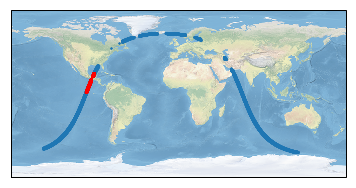

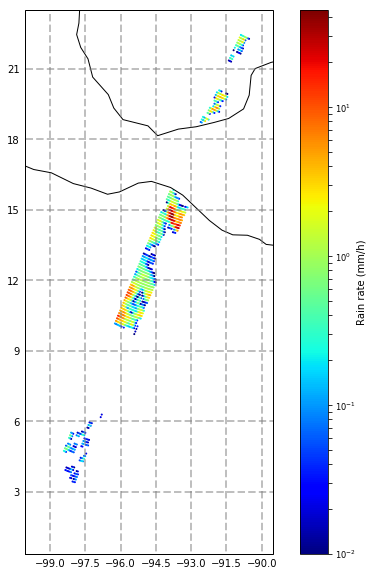

In [16]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

a = 11000# DPR start index
b = 14000 # DPR end index

lons = longitudes[a:b]
lats = latitudes[a:b]
gt_data = labels[a:b]

min_val = 0.01
max_val = np.max(gt_data)
print(max_val)

ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.scatter(longitudes,latitudes, s = 1)
plt.scatter(lons,lats,s=1,c='red')

plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.scatter(lons,lats,marker='o',s=1,c=gt_data,cmap='jet',
            norm = LogNorm(vmin=min_val, vmax = max_val))
cbar = plt.colorbar()
cbar.set_label("Rain rate (mm/h)", labelpad=+1)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True


plt.show()

GT                 GPROF             QRNN 0.9  sec terital      QRNN 0.5
[44.71678161621094, 33.19034194946289, 53.583416, 20.0, 37.454437]
53.58341598510742


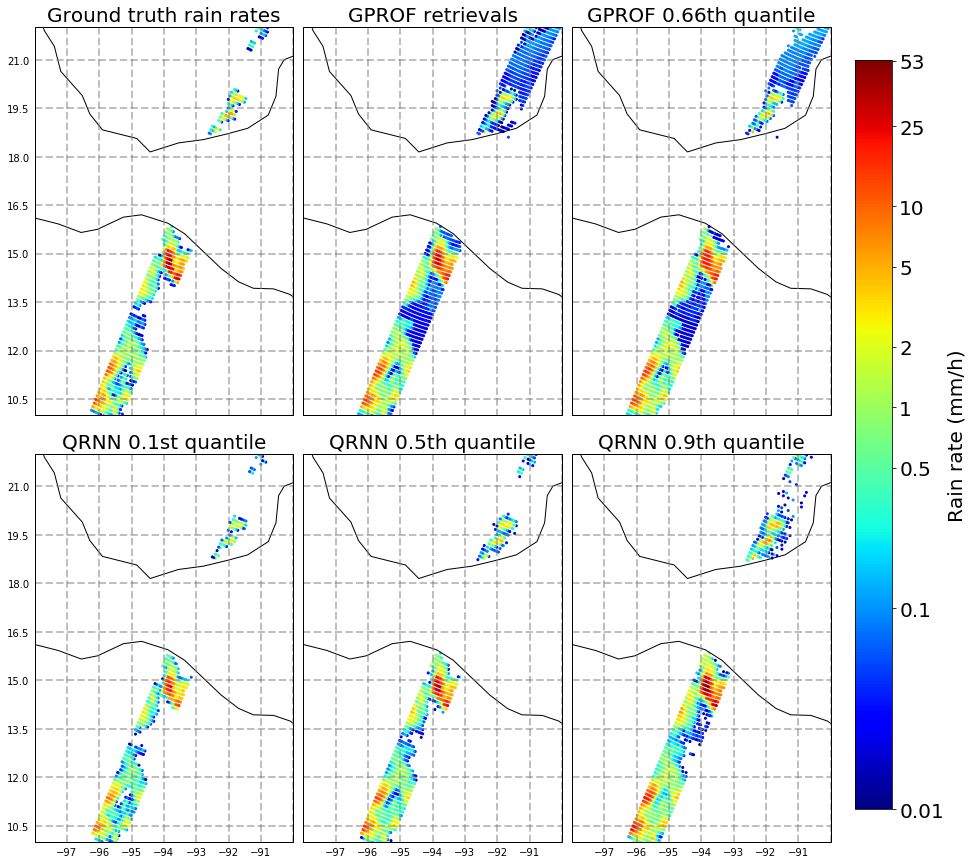

In [30]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(2, 3, subplot_kw=dict(projection=proj),figsize = (20,20))
ax1 = axes.flatten()[0]
ax2 = axes.flatten()[1]
ax3 = axes.flatten()[2]
ax4 = axes.flatten()[3]
ax5 = axes.flatten()[4]
ax6 = axes.flatten()[5]

ymin = 10
ymax = 22
xmin = -98
xmax = -90

threshold = 0.01
DPR_marker = 4
GMI_marker = DPR_marker
color_map = 'jet'
cbar_font = 18
cbar_tick = 15
title_font = 20
frac = 0.043
DPR_edge_col = 'black'
DPR_edge_width = 2
tick_size = 20

qrnn_data_05 = qrnn_05[a:b]
qrnn_data_09 = qrnn_preds[a:b,-2]
qrnn_data_01 = qrnn_preds[a:b,1]
gprof_data   = GPROF_data[a:b]
sec_tertial  = GPROF_066[a:b]


max_vals = [np.max(gt_data), np.max(gprof_data), np.max(qrnn_data_09), np.max(sec_tertial), np.max(qrnn_data_05)]
max_val = np.max(max_vals)
min_val = threshold

print('GT                 GPROF             QRNN 0.9  sec terital      QRNN 0.5')
print(max_vals)
print(max_val)

# PLOT GROUND TRUTH VALUES
rain_ins = np.where(gt_data > threshold)
ax1.coastlines()
plt1 = ax1.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=gt_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax1.set_title('Ground truth rain rates', fontsize = title_font)

# PLOT GPROF RETRIEVALS
rain_ins = np.where(gprof_data > threshold)
ax2.coastlines()
plt2 = ax2.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=gprof_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax2.set_title('GPROF retrievals', fontsize = title_font)

# PLOT GPROF SECOND TERTIAL
rain_ins = np.where(sec_tertial > threshold)
ax3.coastlines()
plt3 = ax3.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=sec_tertial[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax3.set_title('GPROF 0.66th quantile', fontsize = title_font)

# PLOT QRNN 0.1ST QUANTILE
rain_ins = np.where(qrnn_data_01 > threshold)
ax4.coastlines()
plt4 = ax4.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_data_01[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax4.set_xlim([xmin,xmax])
ax4.set_ylim([ymin,ymax])
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax4.set_title('QRNN 0.1st quantile', fontsize = title_font)

# PLOT QRNN MEDIAN
rain_ins = np.where(qrnn_data_05 > threshold)
ax5.coastlines()
plt5 = ax5.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_data_05[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax5.set_xlim([xmin,xmax])
ax5.set_ylim([ymin,ymax])
gl = ax5.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax5.set_title('QRNN 0.5th quantile', fontsize = title_font)

# PLOT QRNN 0.9TH QUANTILE
rain_ins = np.where(qrnn_data_09 > threshold)
ax6.coastlines()
plt6 = ax6.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=qrnn_data_09[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax6.set_xlim([xmin,xmax])
ax6.set_ylim([ymin,ymax])
gl = ax6.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = True
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax6.set_title('QRNN 0.9th quantile', fontsize = title_font)


#fig.text(0.095, 0.82, 'Latitude', va='center', rotation='vertical',fontsize = title_font+2)
#fig.text(0.42, 0.66, 'Longitude', ha='center',fontsize = title_font+2)

fig.tight_layout()
fig.subplots_adjust(bottom = 0.4, left = 0.13, right = 0.8)

formatter = LogFormatter(10, labelOnlyBase=False)
cbar = fig.colorbar(plt1, ax=axes.ravel().tolist(), shrink = 0.9, pad = 0.025,
                   ticks = [0.01,0.1,0.5,1,2,5,10,25,int(max_val)])
cbar.ax.set_yticklabels(['0.01','0.1' ,'0.5','1','2','5','10','25',str(int(max_val))])

cbar.set_label("Rain rate (mm/h)", fontsize = 20)
cbar.ax.tick_params(labelsize=20)



plt.show()

In [31]:
PoP_gprof = GPROF_PoP[a:b]
#threshold = 0.01
print(threshold)
quantiles = [0.01,0.1, 0.2, 0.33, 0.4, 0.5, 0.66, 0.7, 0.8, 0.9,0.99]
PoP_qrnn = []
for i in range(a,b):
    PoP_qrnn.append(get_qrnn_PoP(qrnn_preds[i,:],threshold,quantiles))

0.01


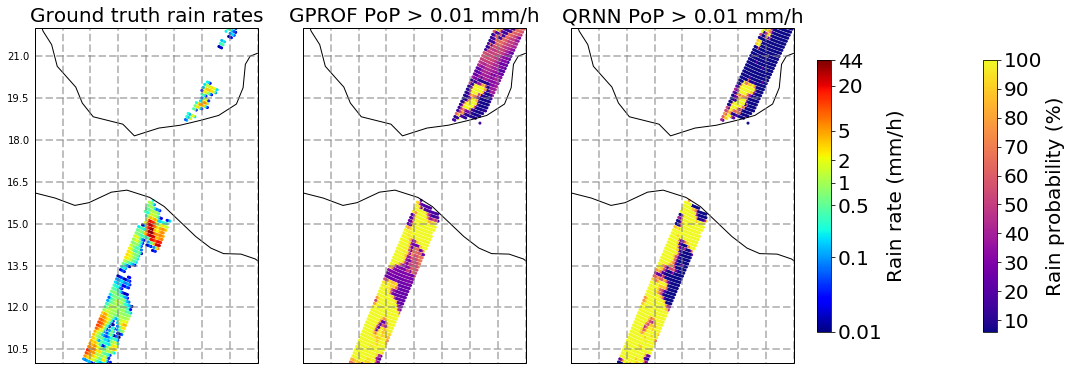

In [32]:
#threshold = 0.01
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 3, subplot_kw=dict(projection=proj),figsize = (20,20))
ax1 = axes.flatten()[0]
ax2 = axes.flatten()[1]
ax3 = axes.flatten()[2]


# PLOT GROUND TRUTH VALUES
min_val = 0.01
max_val = np.max(gt_data)
rain_ins = np.where(gt_data > threshold)
ax1.coastlines()
plt1 = ax1.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=DPR_marker,c=gt_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax1.set_title('Ground truth rain rates', fontsize = title_font)

cmap_pop = 'plasma'
# PLOT GPROF PoP
ax2.coastlines()
plt2 = ax2.scatter(lons,lats,marker='o',s=DPR_marker,c=PoP_gprof, cmap = cmap_pop)
ax2.set_xlim([xmin,xmax])
ax2.set_ylim([ymin,ymax])
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax2.set_title('GPROF PoP > ' + str(threshold) + ' mm/h', fontsize = title_font)

# PLOT QRNN PoP
ax3.coastlines()
plt3 = ax3.scatter(lons,lats,marker='o',s=DPR_marker,c=PoP_qrnn, cmap = cmap_pop)
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax3.set_title('QRNN PoP > ' + str(threshold) + ' mm/h', fontsize = title_font)

cbar = fig.colorbar(plt2, ax=axes.ravel().tolist(), shrink = 0.25, pad = 0.025,
                   ticks = [0,10,20,30,40,50,60,70,80,90,100])

cbar.set_label("Rain probability (%)", fontsize = 20)
cbar.ax.tick_params(labelsize=20)

cbar2 = fig.colorbar(plt1, ax=axes.ravel().tolist(), shrink = 0.25, pad = 0.025,
                   ticks = [0.01,0.1,0.5,1,2,5,20,int(max_val)])
cbar2.ax.set_yticklabels(['0.01','0.1' ,'0.5','1','2','5','20',str(int(max_val))])

cbar2.set_label("Rain rate (mm/h)", fontsize = 20)
cbar2.ax.tick_params(labelsize=20)

In [39]:
PoP_gprof = GPROF_PoP[a:b]
threshold_PoP = 2 
PoP_qrnn = []
for i in range(a,b):
    PoP_qrnn.append(get_qrnn_PoP(qrnn_preds[i,:],threshold_PoP,quantiles))

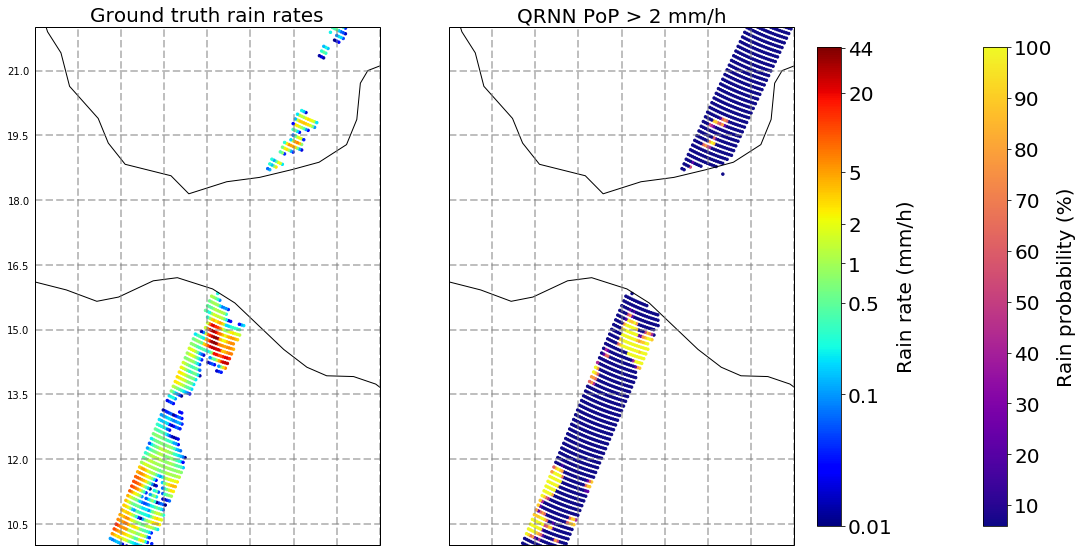

In [40]:
threshold = 0.01
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 2, subplot_kw=dict(projection=proj),figsize = (20,20))
ax1 = axes.flatten()[0]
ax3 = axes.flatten()[1]

marker_size = 6
# PLOT GROUND TRUTH VALUES
min_val = 0.01
max_val = np.max(gt_data)
rain_ins = np.where(gt_data > threshold)
ax1.coastlines()
plt1 = ax1.scatter(lons[rain_ins],lats[rain_ins],marker='o',s=marker_size,c=gt_data[rain_ins],
                   cmap=color_map,norm = LogNorm(vmin=min_val, vmax = max_val))
ax1.set_xlim([xmin,xmax])
ax1.set_ylim([ymin,ymax])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = True
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax1.set_title('Ground truth rain rates', fontsize = title_font)

cmap_pop = 'plasma'

# PLOT QRNN PoP
ax3.coastlines()
plt3 = ax3.scatter(lons,lats,marker='o',s=marker_size,c=PoP_qrnn, cmap = cmap_pop)
ax3.set_xlim([xmin,xmax])
ax3.set_ylim([ymin,ymax])
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_left = False
gl.ylabels_right = False
gl.xlines = True
gl.ylines = True
ax3.set_title('QRNN PoP > ' + str(threshold_PoP) + ' mm/h', fontsize = title_font)

cbar = fig.colorbar(plt2, ax=axes.ravel().tolist(), shrink = 0.44, pad = 0.025,
                   ticks = [0,10,20,30,40,50,60,70,80,90,100])

cbar.set_label("Rain probability (%)", fontsize = 20)
cbar.ax.tick_params(labelsize=20)

cbar2 = fig.colorbar(plt1, ax=axes.ravel().tolist(), shrink = 0.44, pad = 0.025,
                   ticks = [0.01,0.1,0.5,1,2,5,20,int(max_val)])
cbar2.ax.set_yticklabels(['0.01','0.1' ,'0.5','1','2','5','20',str(int(max_val))])

cbar2.set_label("Rain rate (mm/h)", fontsize = 20)
cbar2.ax.tick_params(labelsize=20)

In [44]:
hi_rain_inds = np.where(gt_data > 20)
for a in range(0,len(hi_rain_inds[0])):
    print('---------------------------------------')
    i = hi_rain_inds[0][a]
    print('GT label:       ' + str(gt_data[i]))
    print('QRNN median:    ' + str(qrnn_data_05[i]))
    print('QRNN 0.1:       ' + str(qrnn_data_01[i]))
    print('QRNN 0.9:       ' + str(qrnn_data_09[i]))
    print('GPROF:          ' + str(gprof_data[i]))

---------------------------------------
GT label:       26.469337463378906
QRNN median:    26.868229
QRNN 0.1:       16.318085
QRNN 0.9:       39.948742
GPROF:          20.30125617980957
---------------------------------------
GT label:       26.476106643676758
QRNN median:    21.523287
QRNN 0.1:       13.143076
QRNN 0.9:       32.378445
GPROF:          18.116289138793945
---------------------------------------
GT label:       25.532869338989258
QRNN median:    17.716145
QRNN 0.1:       10.758831
QRNN 0.9:       27.091343
GPROF:          13.379046440124512
---------------------------------------
GT label:       22.88148307800293
QRNN median:    18.225578
QRNN 0.1:       11.127018
QRNN 0.9:       27.950108
GPROF:          18.07496452331543
---------------------------------------
GT label:       21.572509765625
QRNN median:    17.588972
QRNN 0.1:       10.3485985
QRNN 0.9:       27.193707
GPROF:          17.997121810913086
---------------------------------------
GT label:       24.399841

2.983641478374693
26.868229


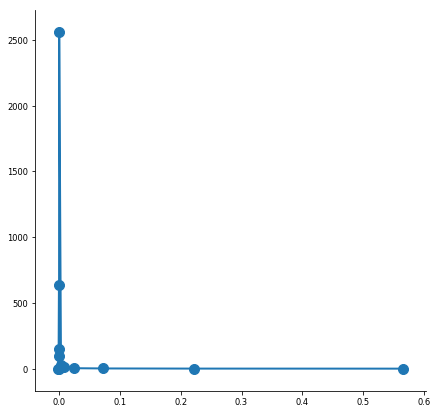

In [51]:
a = 0
i = hi_rain_inds[0][a]
xs, fs  = qrnn.pdf(x_test[i])
fs[fs < 0 ] = 0
exp_val = np.sum(xs * fs) / (xs[-1] - xs[0])
print(exp_val)
print(qrnn_data_05[i])
plt.figure(figsize=(7,7))
plt.plot(xs,fs,linestyle = '-')
plt.scatter(xs,fs)
plt.show()